# Train

In [1]:
%load_ext autoreload
%autoreload 

In [109]:
import torch
import numpy as np
import xarray as xr
from pathlib import Path
import os
import random

import dask
from torch import nn

from hython.preprocess import apply_normalization
from hython.datasets.datasets import LSTMDataset
from hython.train_val import train_val
from hython.sampler import RegularIntervalSampler, DataLoaderSpatialSampler
from hython.metrics import mse_metric
from hython.losses import RMSELoss
from hython.utils import read_from_zarr, missing_location_idx, get_sampler_config, set_seed
from hython.models.lstm import CustomLSTM

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset

# viz
import matplotlib.pyplot as plt
from hython.viz import plot_sampler

# Settings

In [94]:
WFLOW_MODEL =  "datademo"
SURROGATE_MODEL = "demo"
SEED = 1696

dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc","actevap"] 

# DL model hyper parameters
HIDDEN_SIZE = 24
INPUT_SIZE = len(dynamic_names)
OUTPUT_SIZE = len(target_names)
NUMBER_STATIC_PREDICTORS = len(static_names)
TARGET_WEIGHTS = {t:0.5 for t in target_names}

# train/val parameters

train_start = "2016-01-01"
train_end = "2018-12-31"
train_range = slice(train_start,train_end)

EPOCHS = 60
SPATIAL_BATCH_SIZE = 256
TEMPORAL_SAMPLING_SIZE = 150 
SEQ_LENGTH = 360 

# sampler parameters

INTERVALS = [2, 2] # km
TRAIN_ORIGIN = [0, 0]
VAL_ORIGIN = [1, 1]

# missing policy
remove_lakes = True

assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"
TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])

# paths
wd =  Path("../data/datademo")
surrogate_data = wd / f"{WFLOW_MODEL}.zarr"
dp_surrogate_model = wd / SURROGATE_MODEL

In [95]:
set_seed(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [96]:
# Read from preprocessed data, select train range

# train
Xd = read_from_zarr(url=surrogate_data, group="xd", multi_index="gridcell").sel(time = train_range).xd
Xs = read_from_zarr(url=surrogate_data, group="xs", multi_index="gridcell").xs
Y = read_from_zarr(url=surrogate_data, group="y", multi_index="gridcell").sel(time = train_range).y

# other 
# wflow_lakes = Xs.sel(feat="wflow_lakeareas").unstack()
wflow_dem = Xs.sel(feat="wflow_dem").unstack()

# select features and targets 
Xd = Xd.sel(feat=dynamic_names)
Xs = Xs.sel(feat=static_names)
Y = Y.sel(feat=target_names)

print(Xd.shape, Xs.shape, Y.shape)
# read masks
mask_missing = read_from_zarr(url=surrogate_data, group="mask" ).mask
# mask_lake = read_from_zarr(url=surrogate_data, group="mask_lake" ).mask_lake

(1452, 1096, 3) (1452, 6) (1452, 1096, 2)


SamplerResult(
 - id_grid_2d: (44, 33) 
 - idx_sampled_1d: (374,) 
 - idx_sampled_1d_nomissing: (374,)) 
 - idx_missing_1d: (0,) 
 - sampled_grid_dims: (22, 17) 
 - xr_coords: None


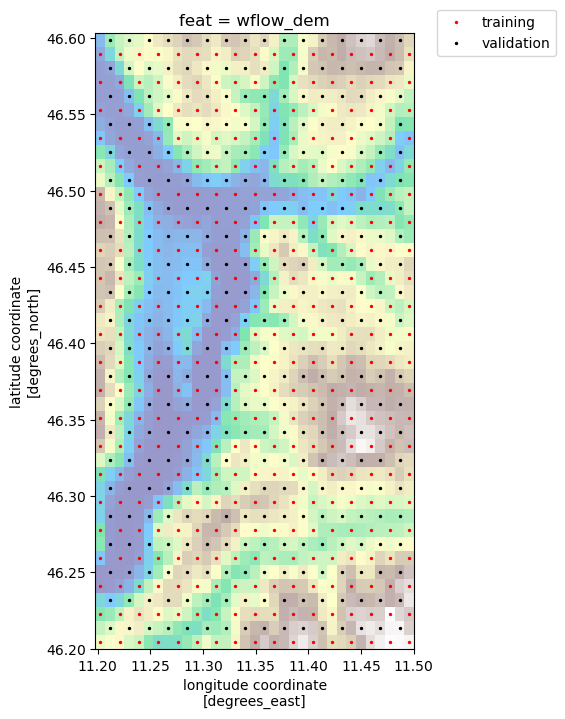

In [97]:
# Define the spatial samplers for both training and validation sets. Remeber the subsets should not overlap, so choose different origins.

# training set
spatial_train_sampler = RegularIntervalSampler(intervals = INTERVALS, origin = TRAIN_ORIGIN)

# validation set
spatial_val_sampler = RegularIntervalSampler(intervals = INTERVALS, origin = VAL_ORIGIN) 

# Apply the samplers: return the cell indices that can be used later in training and validation to sample the whole spatial domain.
data2d  = wflow_dem.values

idx = missing_location_idx(Xs.values)

sampler_train_meta = spatial_train_sampler.sampling_idx(data2d, mask_missing)
sampler_val_meta = spatial_val_sampler.sampling_idx(data2d, mask_missing)

# some useful metadata
print(sampler_train_meta)

# check location of training and validation sets
_ = plot_sampler(wflow_dem, sampler_train_meta, sampler_val_meta, figsize= (8, 8 ), markersize = 2)


In [98]:
print("Percentage of sampled data: ",(len(sampler_train_meta.idx_sampled_1d_nomissing)/ len(Xs[~idx].values.flatten()))*100, "%")

Percentage of sampled data:  4.292929292929292 %


In [99]:
# # Normalizing

# statistics from training set
_, d_m, d_std = apply_normalization(Xd[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')
_, s_m, s_std = apply_normalization(Xs[sampler_train_meta.idx_sampled_1d_nomissing], type = "space", how ='standard')
_, y_m, y_std = apply_normalization(Y[sampler_train_meta.idx_sampled_1d_nomissing], type = "spacetime", how ='standard')

# normalize training set and validation set
Xd = apply_normalization(Xd, type="spacetime", how="standard", m1 = d_m, m2 = d_std).compute()
Xs = apply_normalization(Xs, type="space", how="standard",  m1 = s_m, m2 = s_std).compute()
Y = apply_normalization(Y, type="spacetime",how="standard", m1 = y_m, m2 = y_std).compute()

# Prepare Model inputs

In [100]:

Xs = torch.Tensor(Xs.values)
Xd = torch.Tensor(Xd.values)
Y = torch.Tensor(Y.values)

print(Xs.shape, Xd.shape, Y.shape)

# init datasets
dataset = LSTMDataset(Xd, Y, Xs)

train_sampler = DataLoaderSpatialSampler(dataset, num_samples=1, sampling_indices = sampler_train_meta.idx_sampled_1d_nomissing.tolist())
valid_sampler = DataLoaderSpatialSampler(dataset, num_samples=1, sampling_indices = sampler_val_meta.idx_sampled_1d_nomissing.tolist())

train_loader = DataLoader(dataset, batch_size=SPATIAL_BATCH_SIZE, shuffle=False, sampler = train_sampler) # implement shuffling in the sampler!
val_loader = DataLoader(dataset, batch_size=SPATIAL_BATCH_SIZE, shuffle=False, sampler = valid_sampler)


torch.Size([1452, 6]) torch.Size([1452, 1096, 3]) torch.Size([1452, 1096, 2])


# Initialize Model

In [101]:
model = CustomLSTM(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE, NUMBER_STATIC_PREDICTORS)
model = model.to(device)
model

CustomLSTM(
  (fc0): Linear(in_features=9, out_features=24, bias=True)
  (lstm): LSTM(24, 24, batch_first=True)
  (fc1): Linear(in_features=24, out_features=2, bias=True)
)

# Train/valid settings

In [102]:
path2models= "./checkpoints" 
if not os.path.exists(path2models):
    os.mkdir(path2models)
    
    
opt = optim.Adam(model.parameters(), lr=1e-3)


loss_fn = RMSELoss(target_weight=TARGET_WEIGHTS)


metric_fn = mse_metric

lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=10)

epochs = 90

In [103]:
params_train={
    "num_epochs": EPOCHS,
    "temporal_sampling_idx_change_with_epoch": True,
    "temporal_sampling_size": TEMPORAL_SAMPLING_SIZE,
    "seq_length": SEQ_LENGTH,
    "ts_range": Y.shape[1],
    "optimizer": opt,
    "loss_func": loss_fn,
    "metric_func": metric_fn,
    "train_dl": train_loader, 
    "val_dl": val_loader,
    "lr_scheduler": lr_scheduler,
    "path2weights": f"{path2models}/weights.pt",
    "device":device,
    "target_names": target_names

}

# Run Train/valid

In [104]:
model, sm_loss_history, sm_metric_history = train_val(model, params_train)

  0%|                                                                                            | 0/60 [00:00<?, ?it/s]

Epoch 0/59, current lr=0.001


  2%|█▍                                                                                  | 1/60 [00:01<01:50,  1.87s/it]

Copied best model weights!
train loss: 0.43278586864471436, train metric: {'vwc': 0.54491395, 'actevap': 0.32090554}
val loss: 0.34391987323760986, val metric: {'vwc': 0.29360408, 'actevap': 0.13053447}
----------
Epoch 1/59, current lr=0.001


  3%|██▊                                                                                 | 2/60 [00:03<01:44,  1.80s/it]

Copied best model weights!
train loss: 0.3385257422924042, train metric: {'vwc': 0.3246501, 'actevap': 0.14536859}
val loss: 0.32276713848114014, val metric: {'vwc': 0.25396273, 'actevap': 0.11334822}
----------
Epoch 2/59, current lr=0.001


  5%|████▏                                                                               | 3/60 [00:05<01:41,  1.78s/it]

Copied best model weights!
train loss: 0.2865492105484009, train metric: {'vwc': 0.23945552, 'actevap': 0.095110014}
val loss: 0.2837672829627991, val metric: {'vwc': 0.19817676, 'actevap': 0.08461133}
----------
Epoch 3/59, current lr=0.001


  7%|█████▌                                                                              | 4/60 [00:07<01:38,  1.77s/it]

Copied best model weights!
train loss: 0.27779051661491394, train metric: {'vwc': 0.21126741, 'actevap': 0.090037405}
val loss: 0.2788447439670563, val metric: {'vwc': 0.1922439, 'actevap': 0.07742098}
----------
Epoch 4/59, current lr=0.001


  8%|███████                                                                             | 5/60 [00:08<01:37,  1.77s/it]

Copied best model weights!
train loss: 0.24949167668819427, train metric: {'vwc': 0.18792564, 'actevap': 0.062684745}
val loss: 0.24888388812541962, val metric: {'vwc': 0.17587979, 'actevap': 0.055684023}
----------
Epoch 5/59, current lr=0.001


 10%|████████▍                                                                           | 6/60 [00:10<01:35,  1.76s/it]

Copied best model weights!
train loss: 0.24712017178535461, train metric: {'vwc': 0.1954231, 'actevap': 0.05612452}
val loss: 0.24560488760471344, val metric: {'vwc': 0.17035551, 'actevap': 0.05379102}
----------
Epoch 6/59, current lr=0.001


 12%|█████████▊                                                                          | 7/60 [00:12<01:33,  1.76s/it]

train loss: 0.24036401510238647, train metric: {'vwc': 0.1690968, 'actevap': 0.0687613}
val loss: 0.2510542869567871, val metric: {'vwc': 0.17527768, 'actevap': 0.0613677}
----------
Epoch 7/59, current lr=0.001


 13%|███████████▏                                                                        | 8/60 [00:14<01:31,  1.75s/it]

Copied best model weights!
train loss: 0.23136155307292938, train metric: {'vwc': 0.15593156, 'actevap': 0.05793339}
val loss: 0.23481681942939758, val metric: {'vwc': 0.14897162, 'actevap': 0.05546024}
----------
Epoch 8/59, current lr=0.001


 15%|████████████▌                                                                       | 9/60 [00:15<01:29,  1.76s/it]

Copied best model weights!
train loss: 0.22216735780239105, train metric: {'vwc': 0.15198484, 'actevap': 0.05292985}
val loss: 0.22222813963890076, val metric: {'vwc': 0.13568252, 'actevap': 0.05102108}
----------
Epoch 9/59, current lr=0.001


 17%|█████████████▊                                                                     | 10/60 [00:17<01:27,  1.76s/it]

Copied best model weights!
train loss: 0.21259631216526031, train metric: {'vwc': 0.13742161, 'actevap': 0.052998506}
val loss: 0.21877211332321167, val metric: {'vwc': 0.13287309, 'actevap': 0.045772526}
----------
Epoch 10/59, current lr=0.001


 18%|███████████████▏                                                                   | 11/60 [00:19<01:25,  1.75s/it]

train loss: 0.213370218873024, train metric: {'vwc': 0.13851249, 'actevap': 0.05110862}
val loss: 0.23444002866744995, val metric: {'vwc': 0.15639558, 'actevap': 0.052016288}
----------
Epoch 11/59, current lr=0.001


 20%|████████████████▌                                                                  | 12/60 [00:21<01:24,  1.76s/it]

Copied best model weights!
train loss: 0.21018415689468384, train metric: {'vwc': 0.13915776, 'actevap': 0.04442684}
val loss: 0.20189417898654938, val metric: {'vwc': 0.11547341, 'actevap': 0.03883941}
----------
Epoch 12/59, current lr=0.001


 22%|█████████████████▉                                                                 | 13/60 [00:22<01:22,  1.76s/it]

train loss: 0.2106642723083496, train metric: {'vwc': 0.13560237, 'actevap': 0.049159043}
val loss: 0.2160915583372116, val metric: {'vwc': 0.13268112, 'actevap': 0.048298016}
----------
Epoch 13/59, current lr=0.001


 23%|███████████████████▎                                                               | 14/60 [00:24<01:20,  1.76s/it]

train loss: 0.19585993885993958, train metric: {'vwc': 0.12571606, 'actevap': 0.039329566}
val loss: 0.20351453125476837, val metric: {'vwc': 0.11737039, 'actevap': 0.042451307}
----------
Epoch 14/59, current lr=0.001


 25%|████████████████████▊                                                              | 15/60 [00:26<01:18,  1.75s/it]

train loss: 0.20736496150493622, train metric: {'vwc': 0.12982966, 'actevap': 0.048649795}
val loss: 0.21413911879062653, val metric: {'vwc': 0.12283253, 'actevap': 0.049408995}
----------
Epoch 15/59, current lr=0.001


 27%|██████████████████████▏                                                            | 16/60 [00:28<01:17,  1.75s/it]

train loss: 0.20815110206604004, train metric: {'vwc': 0.13914989, 'actevap': 0.043352168}
val loss: 0.21507243812084198, val metric: {'vwc': 0.13738295, 'actevap': 0.042818736}
----------
Epoch 16/59, current lr=0.001


 28%|███████████████████████▌                                                           | 17/60 [00:29<01:15,  1.75s/it]

train loss: 0.19893138110637665, train metric: {'vwc': 0.12327277, 'actevap': 0.042813435}
val loss: 0.20980556309223175, val metric: {'vwc': 0.12690061, 'actevap': 0.040085804}
----------
Epoch 17/59, current lr=0.001


 30%|████████████████████████▉                                                          | 18/60 [00:31<01:13,  1.75s/it]

Copied best model weights!
train loss: 0.2024296224117279, train metric: {'vwc': 0.12076257, 'actevap': 0.047120977}
val loss: 0.2016061544418335, val metric: {'vwc': 0.113530695, 'actevap': 0.041851822}
----------
Epoch 18/59, current lr=0.001


 32%|██████████████████████████▎                                                        | 19/60 [00:33<01:11,  1.75s/it]

Copied best model weights!
train loss: 0.19167768955230713, train metric: {'vwc': 0.114254, 'actevap': 0.04064703}
val loss: 0.1955217719078064, val metric: {'vwc': 0.1077141, 'actevap': 0.040383432}
----------
Epoch 19/59, current lr=0.001


 33%|███████████████████████████▋                                                       | 20/60 [00:35<01:10,  1.76s/it]

train loss: 0.19736823439598083, train metric: {'vwc': 0.122318394, 'actevap': 0.040127967}
val loss: 0.2145051807165146, val metric: {'vwc': 0.14620188, 'actevap': 0.04295317}
----------
Epoch 20/59, current lr=0.001


 35%|█████████████████████████████                                                      | 21/60 [00:36<01:08,  1.76s/it]

train loss: 0.19551372528076172, train metric: {'vwc': 0.11898609, 'actevap': 0.04334016}
val loss: 0.2094392031431198, val metric: {'vwc': 0.11912383, 'actevap': 0.04576744}
----------
Epoch 21/59, current lr=0.001


 37%|██████████████████████████████▍                                                    | 22/60 [00:38<01:06,  1.76s/it]

Copied best model weights!
train loss: 0.1898835003376007, train metric: {'vwc': 0.117898814, 'actevap': 0.03591833}
val loss: 0.19347445666790009, val metric: {'vwc': 0.11082006, 'actevap': 0.03846556}
----------
Epoch 22/59, current lr=0.001


 38%|███████████████████████████████▊                                                   | 23/60 [00:40<01:05,  1.77s/it]

Copied best model weights!
train loss: 0.18388475477695465, train metric: {'vwc': 0.11460748, 'actevap': 0.0353091}
val loss: 0.1921599805355072, val metric: {'vwc': 0.11684091, 'actevap': 0.042597655}
----------
Epoch 23/59, current lr=0.001


 40%|█████████████████████████████████▏                                                 | 24/60 [00:42<01:03,  1.77s/it]

train loss: 0.18668827414512634, train metric: {'vwc': 0.10974269, 'actevap': 0.041195404}
val loss: 0.1929176300764084, val metric: {'vwc': 0.11037883, 'actevap': 0.04523271}
----------
Epoch 24/59, current lr=0.001


 42%|██████████████████████████████████▌                                                | 25/60 [00:44<01:02,  1.77s/it]

train loss: 0.1843424290418625, train metric: {'vwc': 0.10934989, 'actevap': 0.0354302}
val loss: 0.2014433592557907, val metric: {'vwc': 0.12888803, 'actevap': 0.033703215}
----------
Epoch 25/59, current lr=0.001


 43%|███████████████████████████████████▉                                               | 26/60 [00:45<01:00,  1.77s/it]

train loss: 0.19056323170661926, train metric: {'vwc': 0.11322162, 'actevap': 0.039613746}
val loss: 0.19859565794467926, val metric: {'vwc': 0.11599705, 'actevap': 0.04006933}
----------
Epoch 26/59, current lr=0.001


 45%|█████████████████████████████████████▎                                             | 27/60 [00:47<00:58,  1.77s/it]

Copied best model weights!
train loss: 0.17752064764499664, train metric: {'vwc': 0.10233747, 'actevap': 0.033274814}
val loss: 0.18142952024936676, val metric: {'vwc': 0.101203196, 'actevap': 0.0340757}
----------
Epoch 27/59, current lr=0.001


 47%|██████████████████████████████████████▋                                            | 28/60 [00:49<00:56,  1.78s/it]

train loss: 0.1846487671136856, train metric: {'vwc': 0.10441453, 'actevap': 0.037862077}
val loss: 0.19172385334968567, val metric: {'vwc': 0.10549585, 'actevap': 0.03805318}
----------
Epoch 28/59, current lr=0.001


 48%|████████████████████████████████████████                                           | 29/60 [00:51<00:54,  1.77s/it]

train loss: 0.1862032264471054, train metric: {'vwc': 0.108690225, 'actevap': 0.039772134}
val loss: 0.19461743533611298, val metric: {'vwc': 0.11356698, 'actevap': 0.040103}
----------
Epoch 29/59, current lr=0.001


 50%|█████████████████████████████████████████▌                                         | 30/60 [00:52<00:53,  1.77s/it]

train loss: 0.18806986510753632, train metric: {'vwc': 0.11537146, 'actevap': 0.03630337}
val loss: 0.18677659332752228, val metric: {'vwc': 0.10585054, 'actevap': 0.03870195}
----------
Epoch 30/59, current lr=0.001


 52%|██████████████████████████████████████████▉                                        | 31/60 [00:54<00:51,  1.77s/it]

train loss: 0.18087080121040344, train metric: {'vwc': 0.10057024, 'actevap': 0.03951442}
val loss: 0.19200780987739563, val metric: {'vwc': 0.1120153, 'actevap': 0.0397142}
----------
Epoch 31/59, current lr=0.001


 53%|████████████████████████████████████████████▎                                      | 32/60 [00:56<00:49,  1.78s/it]

train loss: 0.18360888957977295, train metric: {'vwc': 0.10194374, 'actevap': 0.03648599}
val loss: 0.19162388145923615, val metric: {'vwc': 0.09761443, 'actevap': 0.03961423}
----------
Epoch 32/59, current lr=0.001


 55%|█████████████████████████████████████████████▋                                     | 33/60 [00:58<00:48,  1.78s/it]

train loss: 0.19090232253074646, train metric: {'vwc': 0.11913561, 'actevap': 0.033479605}
val loss: 0.20261166989803314, val metric: {'vwc': 0.120766714, 'actevap': 0.03576235}
----------
Epoch 33/59, current lr=0.001


 57%|███████████████████████████████████████████████                                    | 34/60 [01:00<00:46,  1.78s/it]

train loss: 0.17537996172904968, train metric: {'vwc': 0.09767212, 'actevap': 0.03134756}
val loss: 0.1818503886461258, val metric: {'vwc': 0.094638534, 'actevap': 0.033737436}
----------
Epoch 34/59, current lr=0.001


 58%|████████████████████████████████████████████████▍                                  | 35/60 [01:01<00:44,  1.79s/it]

train loss: 0.1777135133743286, train metric: {'vwc': 0.101068676, 'actevap': 0.033285487}
val loss: 0.18646158277988434, val metric: {'vwc': 0.10248642, 'actevap': 0.035814878}
----------
Epoch 35/59, current lr=0.001


 60%|█████████████████████████████████████████████████▊                                 | 36/60 [01:03<00:42,  1.79s/it]

train loss: 0.17430661618709564, train metric: {'vwc': 0.09667544, 'actevap': 0.030667258}
val loss: 0.18979448080062866, val metric: {'vwc': 0.10235326, 'actevap': 0.04312943}
----------
Epoch 36/59, current lr=0.001


 62%|███████████████████████████████████████████████████▏                               | 37/60 [01:05<00:41,  1.79s/it]

train loss: 0.1717206984758377, train metric: {'vwc': 0.097557105, 'actevap': 0.029519953}
val loss: 0.18365292251110077, val metric: {'vwc': 0.10811876, 'actevap': 0.03057615}
----------
Epoch 37/59, current lr=0.001


 63%|████████████████████████████████████████████████████▌                              | 38/60 [01:07<00:41,  1.89s/it]

train loss: 0.17827589809894562, train metric: {'vwc': 0.101397686, 'actevap': 0.03393078}
val loss: 0.18771636486053467, val metric: {'vwc': 0.1064452, 'actevap': 0.03585428}
----------
Epoch 38/59, current lr=0.0005


 65%|█████████████████████████████████████████████████████▉                             | 39/60 [01:09<00:41,  1.97s/it]

Copied best model weights!
train loss: 0.17257794737815857, train metric: {'vwc': 0.09269974, 'actevap': 0.034761928}
val loss: 0.1812947690486908, val metric: {'vwc': 0.0978772, 'actevap': 0.03453208}
----------
Epoch 39/59, current lr=0.0005


 67%|███████████████████████████████████████████████████████▎                           | 40/60 [01:11<00:40,  2.04s/it]

Copied best model weights!
train loss: 0.16758054494857788, train metric: {'vwc': 0.09321879, 'actevap': 0.030294029}
val loss: 0.17507915198802948, val metric: {'vwc': 0.09366791, 'actevap': 0.033033546}
----------
Epoch 40/59, current lr=0.0005


 68%|████████████████████████████████████████████████████████▋                          | 41/60 [01:14<00:39,  2.08s/it]

train loss: 0.16922315955162048, train metric: {'vwc': 0.09453595, 'actevap': 0.028522534}
val loss: 0.18145006895065308, val metric: {'vwc': 0.10568559, 'actevap': 0.031182554}
----------
Epoch 41/59, current lr=0.0005


 70%|██████████████████████████████████████████████████████████                         | 42/60 [01:16<00:38,  2.12s/it]

train loss: 0.16232310235500336, train metric: {'vwc': 0.08838272, 'actevap': 0.02825958}
val loss: 0.175369530916214, val metric: {'vwc': 0.09786363, 'actevap': 0.030624641}
----------
Epoch 42/59, current lr=0.0005


 72%|███████████████████████████████████████████████████████████▍                       | 43/60 [01:18<00:36,  2.15s/it]

train loss: 0.16319605708122253, train metric: {'vwc': 0.08252795, 'actevap': 0.030915072}
val loss: 0.1796557903289795, val metric: {'vwc': 0.09280276, 'actevap': 0.03839268}
----------
Epoch 43/59, current lr=0.0005


 73%|████████████████████████████████████████████████████████████▊                      | 44/60 [01:20<00:34,  2.15s/it]

train loss: 0.1631055325269699, train metric: {'vwc': 0.08296133, 'actevap': 0.029917406}
val loss: 0.17702779173851013, val metric: {'vwc': 0.09858541, 'actevap': 0.029871028}
----------
Epoch 44/59, current lr=0.0005


 75%|██████████████████████████████████████████████████████████████▎                    | 45/60 [01:22<00:32,  2.15s/it]

train loss: 0.1716219037771225, train metric: {'vwc': 0.09296584, 'actevap': 0.031407483}
val loss: 0.18422794342041016, val metric: {'vwc': 0.102723554, 'actevap': 0.03501951}
----------
Epoch 45/59, current lr=0.0005


 77%|███████████████████████████████████████████████████████████████▋                   | 46/60 [01:25<00:30,  2.17s/it]

train loss: 0.16683360934257507, train metric: {'vwc': 0.0939297, 'actevap': 0.027502136}
val loss: 0.1813414841890335, val metric: {'vwc': 0.103000425, 'actevap': 0.03129412}
----------
Epoch 46/59, current lr=0.0005


 78%|█████████████████████████████████████████████████████████████████                  | 47/60 [01:27<00:28,  2.17s/it]

Copied best model weights!
train loss: 0.16256657242774963, train metric: {'vwc': 0.08514292, 'actevap': 0.028342979}
val loss: 0.17117063701152802, val metric: {'vwc': 0.09105939, 'actevap': 0.030143164}
----------
Epoch 47/59, current lr=0.0005


 80%|██████████████████████████████████████████████████████████████████▍                | 48/60 [01:29<00:25,  2.13s/it]

train loss: 0.1638524979352951, train metric: {'vwc': 0.086177774, 'actevap': 0.02919756}
val loss: 0.17722570896148682, val metric: {'vwc': 0.10421284, 'actevap': 0.031419154}
----------
Epoch 48/59, current lr=0.0005


 82%|███████████████████████████████████████████████████████████████████▊               | 49/60 [01:31<00:23,  2.10s/it]

train loss: 0.16769534349441528, train metric: {'vwc': 0.09522433, 'actevap': 0.028437283}
val loss: 0.1737932562828064, val metric: {'vwc': 0.093366005, 'actevap': 0.029942783}
----------
Epoch 49/59, current lr=0.0005


 83%|█████████████████████████████████████████████████████████████████████▏             | 50/60 [01:33<00:21,  2.13s/it]

train loss: 0.17928510904312134, train metric: {'vwc': 0.110868566, 'actevap': 0.03076589}
val loss: 0.18791945278644562, val metric: {'vwc': 0.10814986, 'actevap': 0.033706527}
----------
Epoch 50/59, current lr=0.0005


 85%|██████████████████████████████████████████████████████████████████████▌            | 51/60 [01:35<00:19,  2.12s/it]

train loss: 0.16958679258823395, train metric: {'vwc': 0.089772396, 'actevap': 0.031839546}
val loss: 0.17863063514232635, val metric: {'vwc': 0.096685134, 'actevap': 0.0344098}
----------
Epoch 51/59, current lr=0.0005


 87%|███████████████████████████████████████████████████████████████████████▉           | 52/60 [01:37<00:16,  2.07s/it]

train loss: 0.16863089799880981, train metric: {'vwc': 0.09943312, 'actevap': 0.025672775}
val loss: 0.1718057245016098, val metric: {'vwc': 0.09706933, 'actevap': 0.027096245}
----------
Epoch 52/59, current lr=0.0005


 88%|█████████████████████████████████████████████████████████████████████████▎         | 53/60 [01:39<00:14,  2.08s/it]

Copied best model weights!
train loss: 0.1514974981546402, train metric: {'vwc': 0.075682476, 'actevap': 0.024920883}
val loss: 0.1633150577545166, val metric: {'vwc': 0.0810326, 'actevap': 0.02732504}
----------
Epoch 53/59, current lr=0.0005


 90%|██████████████████████████████████████████████████████████████████████████▋        | 54/60 [01:41<00:12,  2.11s/it]

train loss: 0.16218113899230957, train metric: {'vwc': 0.08173762, 'actevap': 0.030775884}
val loss: 0.16970279812812805, val metric: {'vwc': 0.08680695, 'actevap': 0.031899184}
----------
Epoch 54/59, current lr=0.0005


 92%|████████████████████████████████████████████████████████████████████████████       | 55/60 [01:44<00:10,  2.15s/it]

train loss: 0.1633964627981186, train metric: {'vwc': 0.08759545, 'actevap': 0.028756402}
val loss: 0.17656926810741425, val metric: {'vwc': 0.09883758, 'actevap': 0.031487994}
----------
Epoch 55/59, current lr=0.0005


 93%|█████████████████████████████████████████████████████████████████████████████▍     | 56/60 [01:46<00:08,  2.10s/it]

train loss: 0.15372565388679504, train metric: {'vwc': 0.07548115, 'actevap': 0.025842149}
val loss: 0.1674598604440689, val metric: {'vwc': 0.08630324, 'actevap': 0.029783558}
----------
Epoch 56/59, current lr=0.0005


 95%|██████████████████████████████████████████████████████████████████████████████▊    | 57/60 [01:48<00:06,  2.12s/it]

train loss: 0.16635699570178986, train metric: {'vwc': 0.09312302, 'actevap': 0.027219167}
val loss: 0.20791733264923096, val metric: {'vwc': 0.1569578, 'actevap': 0.03300092}
----------
Epoch 57/59, current lr=0.0005


 97%|████████████████████████████████████████████████████████████████████████████████▏  | 58/60 [01:50<00:04,  2.12s/it]

train loss: 0.16590143740177155, train metric: {'vwc': 0.09556021, 'actevap': 0.027693475}
val loss: 0.1767718344926834, val metric: {'vwc': 0.10110222, 'actevap': 0.029020533}
----------
Epoch 58/59, current lr=0.0005


 98%|█████████████████████████████████████████████████████████████████████████████████▌ | 59/60 [01:52<00:02,  2.15s/it]

train loss: 0.1590946912765503, train metric: {'vwc': 0.08264076, 'actevap': 0.026385833}
val loss: 0.17497141659259796, val metric: {'vwc': 0.099662654, 'actevap': 0.02788137}
----------
Epoch 59/59, current lr=0.0005


100%|███████████████████████████████████████████████████████████████████████████████████| 60/60 [01:54<00:00,  1.91s/it]

train loss: 0.1631043553352356, train metric: {'vwc': 0.08354756, 'actevap': 0.029093448}
val loss: 0.17653727531433105, val metric: {'vwc': 0.0961936, 'actevap': 0.031150192}
----------


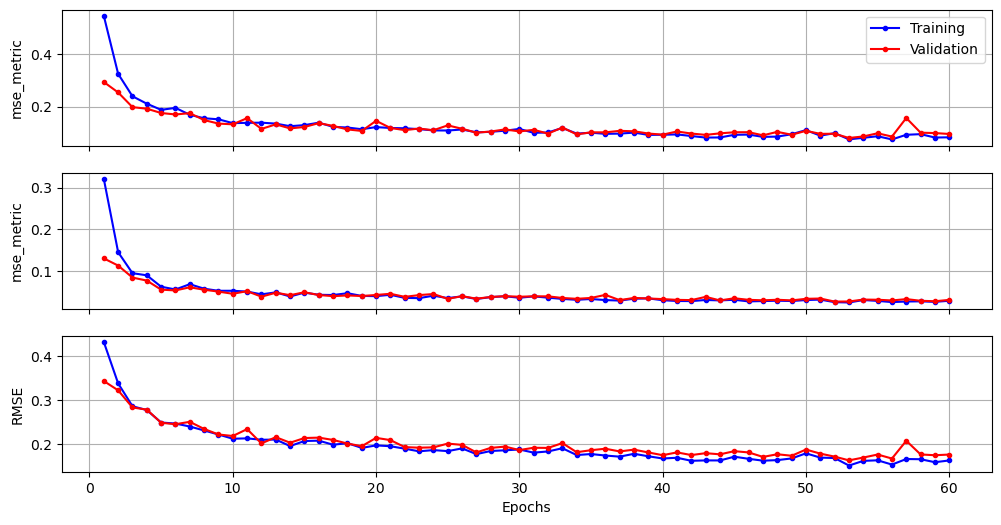

In [105]:
lepochs = list(range(1,params_train["num_epochs"] + 1))

fig, axs = plt.subplots(3, 1, figsize= (12,6), sharex=True)

axs[0].plot(lepochs, sm_metric_history['train_vwc'], marker='.', linestyle='-', color='b', label='Training')
axs[0].plot(lepochs, sm_metric_history['val_vwc'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[0].set_ylabel(metric_fn.__name__)
axs[0].grid(True)
axs[0].legend(bbox_to_anchor=(1,1))

axs[1].plot(lepochs, sm_metric_history['train_actevap'], marker='.', linestyle='-', color='b', label='Training')
axs[1].plot(lepochs, sm_metric_history['val_actevap'], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[1].set_ylabel(metric_fn.__name__)
axs[1].grid(True)

axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['train']], marker='.', linestyle='-', color='b', label='Training')
axs[2].plot(lepochs, [i.detach().cpu().numpy() for i in sm_loss_history['val']], marker='.', linestyle='-', color='r', label='Validation')
#axs[0].title('Validation Loss - SM')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel(loss_fn.__name__)
axs[2].grid(True)

In [110]:
# save model
fp = wd / f"{SURROGATE_MODEL}_v{TARGET_INITIALS}_h{HIDDEN_SIZE}_s{SEED}.pt"
torch.save(model.state_dict(), fp)